# Selección de cripto activos para una cartera de inversión

In [31]:
#from IPython.display import Image
#Image(filename='../imagen_tapa.jpg' ,  width= 1280)

# Trabajo Práctico 3 - Introducción al Aprendizaje Automático

# Introducción

En este práctico aplicaremos algunas técnicas de aprendizaje automático para predecir precios de activos, a partir de los features que hemos trabajado en el práctico anterior. Exploraremos modelos simples de regresión y clasificación. Para validar los modelos procedemos a evaluar su bondad de ajuste, es decir, que "tan bueno" es el poder predictivo del modelo y comparar su desempeño.

**Conjunto de Entrenamiento y Test**

Para entrenar modelos de ML y seleccionar el más adecuado, debemos particionar los datos en conjuntos de entrenamiento y test (o entrenamiento, validación y test). Si bien la práctica más habitual es seleccionar estos conjuntos al azar, esta metodología no es conveniente cuando trabajamos con series de tiempo, ya que romper la estructura de los datos significa romper la autocorrelación, que es lo que da sentido al análisis. Frente a esto, una posibilidad es realizar la división de datos a partir del procedimiento [Walk-Forward Validation](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/), otra es implementar lo que se conoce como [timeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split).

¡Los invito a indagar sobre estas metodologías!

**Variables Predictoras**

Los predictores son datos que consideramos relevantes para el comportamiento del mercado. En nuestro caso, trabajaremos con los indicadores técnicos calculados en el trabajo práctico anterior, pero estos pueden ser muy diversos, como datos de sentimiento, datos de amplitud, datos básicos, gubernamentales, etc., que nos ayudarán a hacer nuestras predicciones. 


# ¡Actividades!

En este práctico evaluaremos el potencial de modelos predictivos simples sobre algunos activos. Esta será la base para construir una canasta de activos con riesgo controlado. 

**¡Para tener en cuenta!**

Es esencial el preprocesamiento de datos, parte de esta tarea fue realizada en el TP anterior. Sin embargo, nos tomaremos un tiempo para revisarlo.

- ¿Hay valores faltantes/perdidos en nuestro set de datos? ¿ya fueron tratados?

- Vimos que si la varianza de los features con los que trabajaremos difieren en magnitud, esto podría entorpecer nuestro trabajo, ¿qué hicimos al respecto?

**¡¡¡Importante!!!**

El valor de algunos indicadores tal cual los hemos calculado no nos sirve, sino que debemos trabajar con las señales que ellos nos brindan. Es el caso de MACD y las medias móviles. Por ello, podemos trabajar con las siguientes columnas:

```
df['ClgtS10'] = np.where(df['Close'] > df['S10'], 1, -1)
df['S10gtS30'] = np.where(df['S10'] > df['S30'], 1, -1)
df['MACDSIGgtMACD'] = np.where(df['MACDsignal'] > df['MACD'], 1, -1)
```
Esto es porque, por ejemplo, es valor de una media móvil de 10 periodos, nada nos dice sobre la condición del mercado. Sin embargo, si comparamos el valor del precio del activo con el valor de la media móvil, el primero se encuentra por encima del segundo, esto indica que el activo está recuperando su valor. 

Estos ejemplos son a modo ilustrativo y dependerá de los indicadores con lo que hayan decidido trabajar. 

## Parte I

En esta etapa nuestro objetivo es implementar un modelo de regresión lineal sobre algún activo para predecir su tasa de cambio (ya sea respecto al precio open o close). Para comenzar nuestra tarea, es suficiente elegir 2 o 3 activos y considerar los features calculados anteriormente (sientanse libres de agregar cualquier otra característica que les parezca interesante)

Evalúen los resultados, con algunas métricas útiles para problemas de regresión, tales como Error Cuadrático Medio (RMSE), el Error Absoluto Medio (MAE) y Error Absoluto Mediano (MedAE).

Grafiquen la serie de precios y los resultados de su predicción. ¿Qué pueden decir?


## Parte II 

Creen un árbol de decisión de regresión (usando la función DecisionTreeRegressor de sklearn) para predecir el rendimiento específico del activo en la sesión siguiente, el árbol de decisiones debería ayudarnos a elegir la mejor combinación de indicadores y sus parámetros para maximizar el resultado esperado. Exploren diferentes valores para los parámetros del algoritmo (criterion, max_depth, min_samples_leaf).

Visualicen alguno de los árboles. 


## Parte III - Opcional
 
- Repitan algunos de los experimentos utilizando diferentes temporalidades (1 hora, 1 día, 1 semana). 
- Apliquen árboles de clasificación para decidir si un activo mantendrá su precio, subirá o disminuirá. Observación: Pueden utlizar las mismas variables predictoras que en el caso de árboles de regresión, solo deben modificar la variable target. 

**¡Recuerden!** 

Nunca Modificar los Datos Crudos u Originales Al finalizar la limpieza, deberán guardar el dataset resultante, para asegurarse de no modificar los datos originales.

# Fecha de entrega

- __Versión preliminar: 15/8__ 

- __Versión final: 22/8__

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

In [32]:
!pip uninstall scikit-learn -y      
!pip install -U -q scikit-learn

Found existing installation: scikit-learn 1.0
Uninstalling scikit-learn-1.0:
  Successfully uninstalled scikit-learn-1.0


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
df_features = pd.read_parquet('https://drive.google.com/uc?id=1F7iNl24V2q1ML4KBbvSlCa1S_QieEc__')

# Preprocesamiento

In [37]:
# Nos quedamos con BTC y ETH
df_btc = df_features.loc[:,df_features.columns.str.contains('BTC')].copy()
df_eth = df_features.loc[:,df_features.columns.str.contains('ETH')].copy()

## Indicadores adicionales

In [38]:
btc_MA = [col for col in df_btc if col.find('_MA')>0 and col.find('volume')==-1]
for i in btc_MA:
    new_col_name = i[8:]
    df_btc[f'BTCUSDT_Clgt_{new_col_name}'] = np.where(df_btc['BTCUSDT_close'] > df_btc[i], 1, -1)

df_btc = df_btc.drop(btc_MA, axis=1)

In [39]:
eth_MA = [col for col in df_eth if col.find('_MA')>0 and col.find('volume')==-1]
for i in eth_MA:
    new_col_name = i[8:]
    df_eth[f'ETHUSDT_Clgt_{new_col_name}'] = np.where(df_eth['ETHUSDT_close'] > df_eth[i], 1, -1)

df_eth = df_eth.drop(eth_MA, axis=1)

In [40]:
df_btc['BTCUSDT_target'] = df_btc.BTCUSDT_close_pct.shift(-1, fill_value=0)
df_eth['ETHUSDT_target'] = df_eth.ETHUSDT_close_pct.shift(-1, fill_value=0)
df_btc.drop('BTCUSDT_close_pct', axis=1, inplace=True)
df_eth.drop('ETHUSDT_close_pct', axis=1, inplace=True)

Dropeamos columnas que no necesitamos

In [41]:
#Deberíamos dropear las que no son target_pct?
df_btc = df_btc.drop(['BTCUSDT_close', 'BTCUSDT_open_pct', 'BTCUSDT_high_pct', 'BTCUSDT_low_pct', 'BTCUSDT_volume_pct'], axis=1)
df_eth = df_eth.drop(['ETHUSDT_close', 'ETHUSDT_open_pct', 'ETHUSDT_high_pct', 'ETHUSDT_low_pct', 'ETHUSDT_volume_pct'], axis=1)

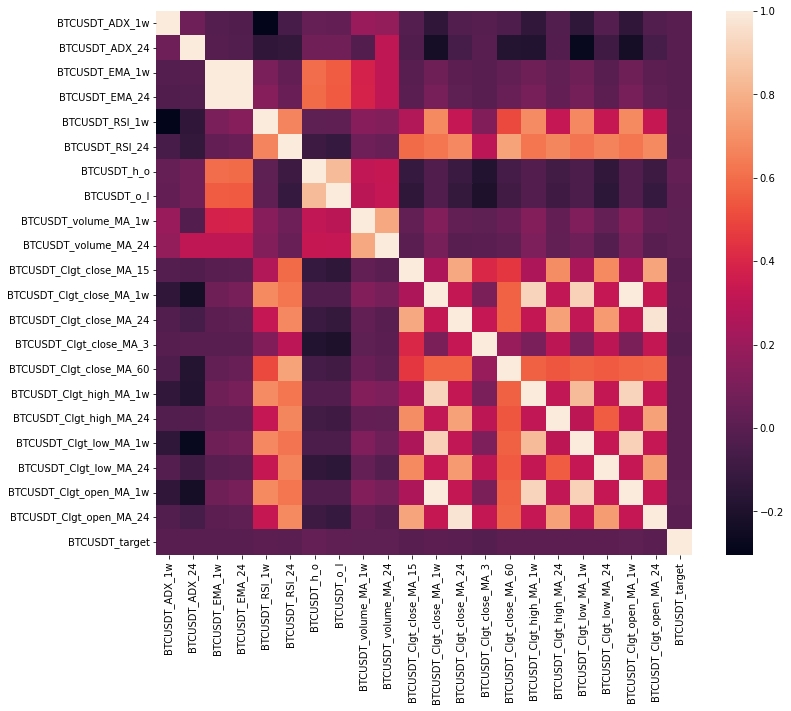

In [42]:
plt.subplots(figsize=(12,10))
sns.heatmap(df_btc.corr())

## Valores nulos

In [43]:
df_btc.isna().sum()

BTCUSDT_ADX_1w              335
BTCUSDT_ADX_24               47
BTCUSDT_EMA_1w              167
BTCUSDT_EMA_24               23
BTCUSDT_RSI_1w              168
BTCUSDT_RSI_24               24
BTCUSDT_h_o                   0
BTCUSDT_o_l                   0
BTCUSDT_volume_MA_1w        167
BTCUSDT_volume_MA_24         23
BTCUSDT_Clgt_close_MA_15      0
BTCUSDT_Clgt_close_MA_1w      0
BTCUSDT_Clgt_close_MA_24      0
BTCUSDT_Clgt_close_MA_3       0
BTCUSDT_Clgt_close_MA_60      0
BTCUSDT_Clgt_high_MA_1w       0
BTCUSDT_Clgt_high_MA_24       0
BTCUSDT_Clgt_low_MA_1w        0
BTCUSDT_Clgt_low_MA_24        0
BTCUSDT_Clgt_open_MA_1w       0
BTCUSDT_Clgt_open_MA_24       0
BTCUSDT_target                0
dtype: int64

In [44]:
df_eth.isna().sum()

ETHUSDT_ADX_1w              335
ETHUSDT_ADX_24               47
ETHUSDT_EMA_1w              167
ETHUSDT_EMA_24               23
ETHUSDT_RSI_1w              168
ETHUSDT_RSI_24               24
ETHUSDT_h_o                   0
ETHUSDT_o_l                   0
ETHUSDT_volume_MA_1w        167
ETHUSDT_volume_MA_24         23
ETHUSDT_Clgt_close_MA_15      0
ETHUSDT_Clgt_close_MA_1w      0
ETHUSDT_Clgt_close_MA_24      0
ETHUSDT_Clgt_close_MA_3       0
ETHUSDT_Clgt_close_MA_60      0
ETHUSDT_Clgt_high_MA_1w       0
ETHUSDT_Clgt_high_MA_24       0
ETHUSDT_Clgt_low_MA_1w        0
ETHUSDT_Clgt_low_MA_24        0
ETHUSDT_Clgt_open_MA_1w       0
ETHUSDT_Clgt_open_MA_24       0
ETHUSDT_target                0
dtype: int64

Los valores faltantes que se encuentran están todos ubicados al principio del dataframe y están referidos a indicadores que requieren una cantidad mínima de tiempo para poder devolver un valor, por lo que decidimos partir del primer período en donde no hay ningun dato nulo.

También estandarizaremos los datos para el caso de regresión lineal, ya que hay magnitudes distintas entre los distintos indicadores y pueden ser sumamente distorsivas para el modelo. Para el caso de árboles de decisión, dado que cada bifurcación se hace en base a un solo feature, es inmune a las distintas escalas.

In [45]:
df_btc = df_btc[335:]
df_eth = df_eth[335:]

In [46]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=4)
# for train, test in tscv.split(df_btc):
#     print("%s %s" % (train, test))

In [47]:
def trainPredict(model, xtrain, ytrain, xtest):

    #Entrenamos el modelo
    model.fit(xtrain, ytrain)

    #Hacemos la predicción 
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    return y_train_pred, y_test_pred

def trainErrors(y, y_pred):  

    msq_train = mean_squared_error(y, y_pred)
    mae_train = mean_absolute_error(y, y_pred)
    meae_train = median_absolute_error(y, y_pred)

    return msq_train, mae_train, meae_train

def testErrors(y, y_pred):

    msq_test = mean_squared_error(y, y_pred)
    mae_test = mean_absolute_error(y, y_pred)
    meae_test = median_absolute_error(y, y_pred)

    return msq_test, mae_test, meae_test

def plotPred(y, ypred, xaxis):

    plt.subplots(figsize=(10,6))
    ax = sns.lineplot(data=y, label='y_test')
    sns.lineplot(data=pd.Series(data=ypred, index=xaxis), ax=ax, alpha = 0.3, label='y_test_pred')
    plt.legend()


# Bitcoin

In [48]:
btc_res = pd.DataFrame(index=['train_mean_squared_error', 'train_median_absolute_error', 'train_mean_absolute_error', 
                                 'test_mean_squared_error', 'test_median_absolute_error', 'test_mean_absolute_error'], 
                          columns=['baseline','linreg', 'tree'], )
btc_res

,baseline,linreg,tree
train_mean_squared_error,NaN,NaN,NaN
train_median_absolute_error,NaN,NaN,NaN
train_mean_absolute_error,NaN,NaN,NaN
test_mean_squared_error,NaN,NaN,NaN
test_median_absolute_error,NaN,NaN,NaN
test_mean_absolute_error,NaN,NaN,NaN


In [49]:
# Train/test manual usando ~168h para test
n = len(df_btc)
n_1w = df_btc.index[-168]
n_1w_ = df_btc.index[-167]

X_train = df_btc.loc[:n_1w, :].drop('BTCUSDT_target', axis=1) #df_btc.loc[:n_1w, :].drop('BTCUSDT_close_pct', axis=1)
y_train = df_btc.loc[:n_1w, 'BTCUSDT_target']#df_btc.loc[:n_1w, 'BTCUSDT_close_pct']

X_test = df_btc.loc[n_1w_:, :].drop('BTCUSDT_target', axis=1)#df_btc.loc[n_1w_:, :].drop('BTCUSDT_close_pct', axis=1)
y_test = df_btc.loc[n_1w_:, 'BTCUSDT_target']#df_btc.loc[n_1w_:, 'BTCUSDT_close_pct']
X_test = X_test.iloc[1:]
y_test = y_test.iloc[1:]

In [50]:
# plt.subplots(figsize=(10,6))
# ax = sns.lineplot(data=y_train.loc[y_train.index[-1500]:], label='y_train')
# sns.lineplot(data=y_test, ax=ax, alpha = 0.3, label='y_test')
# plt.legend()


In [51]:
scaler = StandardScaler()
df_btc_train_scaled = scaler.fit_transform(X_train)
df_btc_train_scaled = pd.DataFrame(data=df_btc_train_scaled, columns=X_train.columns, index=X_train.index)

df_btc_test_scaled = scaler.transform(X_test)
df_btc_test_scaled = pd.DataFrame(data=df_btc_test_scaled, columns=X_test.columns, index=X_test.index)


##  Baseline 


In [52]:
naive_train_pred = y_train.shift(1).fillna(method='bfill')
naive_test_pred = y_test.shift(1).fillna(method='bfill')

msq_train, mae_train, meae_train = trainErrors(y_train, naive_train_pred)
msq_test, mae_test, meae_test = testErrors(y_test, naive_test_pred)
print(f'Train mean_squared_error: {msq_train}')
print(f'Train mean_absolute_error: {mae_train}')
print(f'Train median_absolute_error: {meae_train}\n')
print(f'Test mean_squared_error: {msq_test}')
print(f'Test mean_absolute_error: {mae_test}')
print(f'Test median_absolute_error: {meae_test}')


Train mean_squared_error: 0.00015547520710669992
Train mean_absolute_error: 0.0075056762815342605
Train median_absolute_error: 0.004488399846407254

Test mean_squared_error: 0.00021365807888413016
Test mean_absolute_error: 0.011250419637535716
Test median_absolute_error: 0.008553099230426409


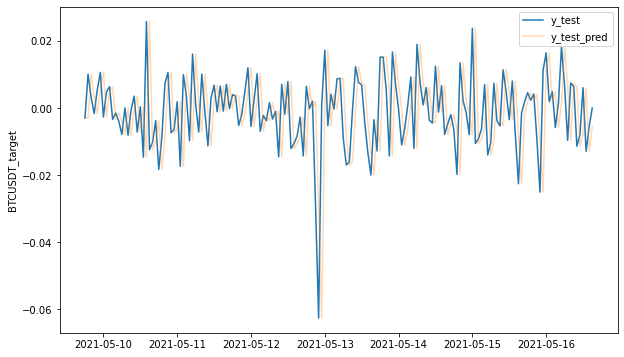

In [53]:
plotPred(y_test, naive_test_pred, df_btc_test_scaled.index)

In [54]:
btc_res['baseline'] = [msq_train, mae_train, meae_train, msq_test, mae_test, meae_test]

## Regresión Lineal

In [55]:
y_train_pred, y_test_pred = trainPredict(LinearRegression(), df_btc_train_scaled, y_train, df_btc_test_scaled)

msq_train, mae_train, meae_train = trainErrors(y_train, y_train_pred)
msq_test, mae_test, meae_test = testErrors(y_test, y_test_pred)
print(f'Train mean_squared_error: {msq_train}')
print(f'Train mean_absolute_error: {mae_train}')
print(f'Train median_absolute_error: {meae_train}\n')
print(f'Test mean_squared_error: {msq_test}')
print(f'Test mean_absolute_error: {mae_test}')
print(f'Test median_absolute_error: {meae_test}')

Train mean_squared_error: 7.437875857679555e-05
Train mean_absolute_error: 0.004911001974145679
Train median_absolute_error: 0.002727262088096722

Test mean_squared_error: 0.00011591241238200682
Test mean_absolute_error: 0.008001732819333075
Test median_absolute_error: 0.006574223068819019


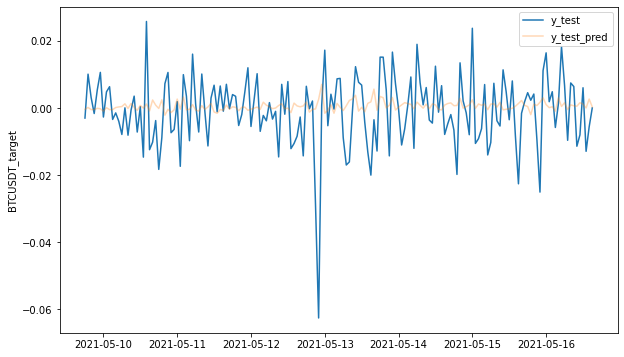

In [56]:
plotPred(y_test, y_test_pred, df_btc_test_scaled.index)

In [57]:
btc_res['linreg'] = [msq_train, mae_train, meae_train, msq_test, mae_test, meae_test]

El modelo es capaz de prendecir con exactitud si el retorno será positivo o negativo, pero tiende a exagerar la mangnitud del mismo para ambos casos. 

Los errores absolutos medio y mediano en test son mayores a los de train, lo que sugiere que puede haber algo de sobreajuste en el modelo.


## Árboles de decision

In [58]:
tscv = TimeSeriesSplit(n_splits=4, test_size=168)

param_grid = {
    'max_depth': [15, None],
    'min_samples_split' : [2,5, 10],
    'min_samples_leaf': [12, 15, 20],
    'max_features' : [0.5, 'auto'], 
    }

model = DecisionTreeRegressor(random_state=42)
gs_tree = GridSearchCV(estimator=model, param_grid = param_grid, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)

gs_tree.fit(df_btc.drop('BTCUSDT_target', axis=1), df_btc['BTCUSDT_target'])

results = gs_tree.cv_results_
res = pd.DataFrame(results).sort_values('rank_test_score', ascending=True)


In [59]:
res[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 
     'param_max_features', 'mean_test_score', 'rank_test_score']].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score,rank_test_score
3,15,2,15,0.5,-0.006602,1
4,15,5,15,0.5,-0.006602,1
5,15,10,15,0.5,-0.006602,1
6,15,2,20,0.5,-0.006971,4
7,15,5,20,0.5,-0.006971,4


In [60]:
# Recreamos el split, nos quedamos con el último
tscv = TimeSeriesSplit(n_splits=4, test_size=168)
for i, (train, test) in enumerate(tscv.split(df_btc)):
    if i == 3:
        X_train = df_btc.iloc[train,:].drop('BTCUSDT_target', axis=1)
        y_train = df_btc.iloc[train, :].BTCUSDT_target
        X_test = df_btc.iloc[test,:].drop('BTCUSDT_target', axis=1)
        y_test = df_btc.iloc[test, :].BTCUSDT_target

##
y_train_pred = gs_tree.best_estimator_.predict(X_train)
y_test_pred = gs_tree.best_estimator_.predict(X_test)


In [61]:
msq_train, mae_train, meae_train = trainErrors(y_train, y_train_pred)
msq_test, mae_test, meae_test = testErrors(y_test, y_test_pred)
print(f'Train mean_squared_error: {msq_train}')
print(f'Train mean_absolute_error: {mae_train}')
print(f'Train median_absolute_error: {meae_train}\n')
print(f'Test mean_squared_error: {msq_test}')
print(f'Test mean_absolute_error: {mae_test}')
print(f'Test median_absolute_error: {meae_test}')

Train mean_squared_error: 7.207593689293006e-05
Train mean_absolute_error: 0.004888041955960006
Train median_absolute_error: 0.002740277183286239

Test mean_squared_error: 0.00012196130192913512
Test mean_absolute_error: 0.007988310057389899
Test median_absolute_error: 0.006563770305278444


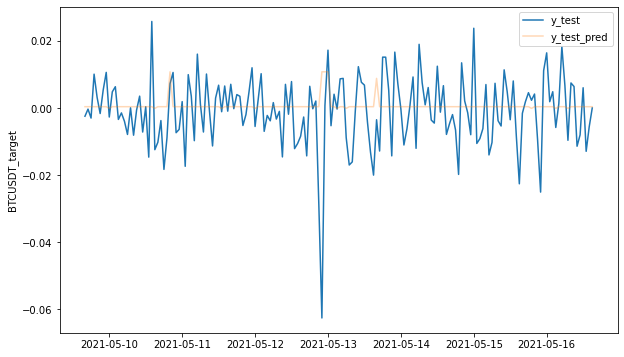

In [62]:
plotPred(y_test, y_test_pred, X_test.index)

In [63]:
btc_res['tree'] = [msq_train, mae_train, meae_train, msq_test, mae_test, meae_test]
btc_res

,baseline,linreg,tree
train_mean_squared_error,0.000155,0.000074,0.000072
train_median_absolute_error,0.007506,0.004911,0.004888
train_mean_absolute_error,0.004488,0.002727,0.002740
test_mean_squared_error,0.000214,0.000116,0.000122
test_median_absolute_error,0.011250,0.008002,0.007988
test_mean_absolute_error,0.008553,0.006574,0.006564


In [30]:
# es muy grande el arbol :(,graficamos solo 2 niveles)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(gs_tree.best_estimator_, max_depth=2, feature_names=df_btc.drop('BTCUSDT_close_pct', axis=1).columns)

NameError: ignored

<Figure size 1800x1440 with 0 Axes>

# Modelos Ether

In [ ]:
eth_res = pd.DataFrame(index=['train_mean_squared_error', 'train_median_absolute_error', 'train_mean_absolute_error', 
                                 'test_mean_squared_error', 'test_median_absolute_error', 'test_mean_absolute_error'], 
                          columns=['baseline','linreg', 'tree'], )
eth_res

In [ ]:
# Train/test manual
n = len(df_eth)
n_1w = df_eth.index[-168]

X_train = df_eth.loc[:n_1w, :].drop('ETHUSDT_target', axis=1)#df_eth.loc[:n_1w, :].drop('ETHUSDT_close_pct', axis=1)
y_train = df_eth.loc[:n_1w, 'ETHUSDT_target']#df_eth.loc[:n_1w, 'ETHUSDT_close_pct']

X_test = df_eth.loc[n_1w:, :].drop('ETHUSDT_target', axis=1)#df_eth.loc[n_1w:, :].drop('ETHUSDT_close_pct', axis=1)
y_test = df_eth.loc[n_1w:, 'ETHUSDT_target']#df_eth.loc[n_1w:, 'ETHUSDT_close_pct']
X_test = X_test.iloc[1:]
y_test = y_test.iloc[1:]

In [ ]:
scaler = StandardScaler()
df_eth_train_scaled = scaler.fit_transform(X_train)
df_eth_train_scaled = pd.DataFrame(df_eth_train_scaled)
df_eth_train_scaled.columns = X_train.columns
df_eth_train_scaled.index = X_train.index

df_eth_test_scaled = scaler.transform(X_test)
df_eth_test_scaled = pd.DataFrame(df_eth_test_scaled)
df_eth_test_scaled.columns = X_test.columns
df_eth_test_scaled.index = X_test.index

## Baseline

In [ ]:
naive_train_pred = y_train.shift(1).fillna(method='bfill')
naive_test_pred = y_test.shift(1).fillna(method='bfill')

msq_train, mae_train, meae_train = trainErrors(y_train, naive_train_pred)
msq_test, mae_test, meae_test = testErrors(y_test, naive_test_pred)
print(f'Train mean_squared_error: {msq_train}')
print(f'Train mean_absolute_error: {mae_train}')
print(f'Train median_absolute_error: {meae_train}\n')
print(f'Test mean_squared_error: {msq_test}')
print(f'Test mean_absolute_error: {mae_test}')
print(f'Test median_absolute_error: {meae_test}')


In [ ]:
plotPred(y_test, naive_test_pred, df_eth_test_scaled.index)

In [ ]:
eth_res['baseline'] = [msq_train, mae_train, meae_train, msq_test, mae_test, meae_test]

## Regresión lineal

In [ ]:
y_train_pred, y_test_pred = trainPredict(LinearRegression(), df_eth_train_scaled, y_train, df_eth_test_scaled)

msq_train, mae_train, meae_train = trainErrors(y_train, y_train_pred)
msq_test, mae_test, meae_test = testErrors(y_test, y_test_pred)
print(f'Train mean_squared_error: {msq_train}')
print(f'Train mean_absolute_error: {mae_train}')
print(f'Train median_absolute_error: {meae_train}\n')
print(f'Test mean_squared_error: {msq_test}')
print(f'Test mean_absolute_error: {mae_test}')
print(f'Test median_absolute_error: {meae_test}')

In [ ]:
plotPred(y_test, y_test_pred, df_eth_test_scaled.index)

In [ ]:
eth_res['linreg'] = [msq_train, mae_train, meae_train, msq_test, mae_test, meae_test]

En este modelo ocurre lo mismo que pasó cuando se entrenó con los datos de Bitcoin. Captura la tendencia positiva o negativa pero las exagera, y los errores absolutos mediano y medio son mayores en test que en train.

## Árboles de decisión


In [ ]:
tscv = TimeSeriesSplit(n_splits=4, test_size=168)

param_grid = {
    'max_depth': [15, None],
    'min_samples_split' : [2,5, 10],
    'min_samples_leaf': [12, 15, 20],
    'max_features' : [0.5, 'auto'], 
    }

model = DecisionTreeRegressor(random_state=42)
gs_tree = GridSearchCV(estimator=model, param_grid = param_grid, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)

gs_tree.fit(df_eth.drop('ETHUSDT_target', axis=1), df_eth['ETHUSDT_target'])

results = gs_tree.cv_results_
res = pd.DataFrame(results).sort_values('rank_test_score', ascending=True)


In [ ]:
res[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 
     'param_max_features', 'mean_test_score', 'rank_test_score']].head()

In [ ]:
# Recreamos el split, nos quedamos con el último
tscv = TimeSeriesSplit(n_splits=4, test_size=168)
for i, (train, test) in enumerate(tscv.split(df_eth)):
    if i == 3:
        X_train = df_eth.iloc[train,:].drop('ETHUSDT_target', axis=1)
        y_train = df_eth.iloc[train, :].ETHUSDT_target
        X_test = df_eth.iloc[test,:].drop('ETHUSDT_target', axis=1)
        y_test = df_eth.iloc[test, :].ETHUSDT_target

##
y_train_pred = gs_tree.best_estimator_.predict(X_train)
y_test_pred = gs_tree.best_estimator_.predict(X_test)


In [ ]:
msq_train, mae_train, meae_train = trainErrors(y_train, y_train_pred)
msq_test, mae_test, meae_test = testErrors(y_test, y_test_pred)
print(f'Train mean_squared_error: {msq_train}')
print(f'Train mean_absolute_error: {mae_train}')
print(f'Train median_absolute_error: {meae_train}\n')
print(f'Test mean_squared_error: {msq_test}')
print(f'Test mean_absolute_error: {mae_test}')
print(f'Test median_absolute_error: {meae_test}')

In [ ]:
plotPred(y_test, y_test_pred, X_test.index)

In [ ]:
eth_res['tree'] = [msq_train, mae_train, meae_train, msq_test, mae_test, meae_test]
eth_res

In [ ]:
# es muy grande el arbol :(,graficamos solo 2 niveles)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(gs_tree.best_estimator_, max_depth=2, feature_names=df_eth.drop('ETHUSDT_close_pct', axis=1).columns)